In [21]:
import scanpy as sc 
import numpy as np 
import pandas as pd 


In [22]:
scdata = sc.read_h5ad('multi_raw.h5ad')
scdata 

AnnData object with n_obs × n_vars = 21861 × 9911
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype', 'eco', 'leiden_R', 'new_leiden', 'new_anno', 'split_label', 'sly_anno'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltype_colors', 'dendrogram_new_anno', 'eco_colors', 'hvg', 'leiden', 'leiden_R', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'new_anno_colors', 'new_leiden_colors', 'pca', 'rank_genes_groups', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
# sc.tl.rank_genes_groups(scdata, groupby = 'eco')
# df = sc.get.rank_genes_groups_df(scdata, group = 'eco')
# eco_gene = df['names'][:1000].values 
# neco_gene = df['names'][-1000:].values
# sc.pp.highly_variable_genes(scdata, n_top_genes = 1000)
# idx = scdata.var['gene_ids'][scdata.var.highly_variable] 
# hvg = np.concatenate([eco_gene, neco_gene, idx])
# hvg = np.unique(hvg)
# scdata = scdata[:,hvg]
# sc.tl.pca(scdata)

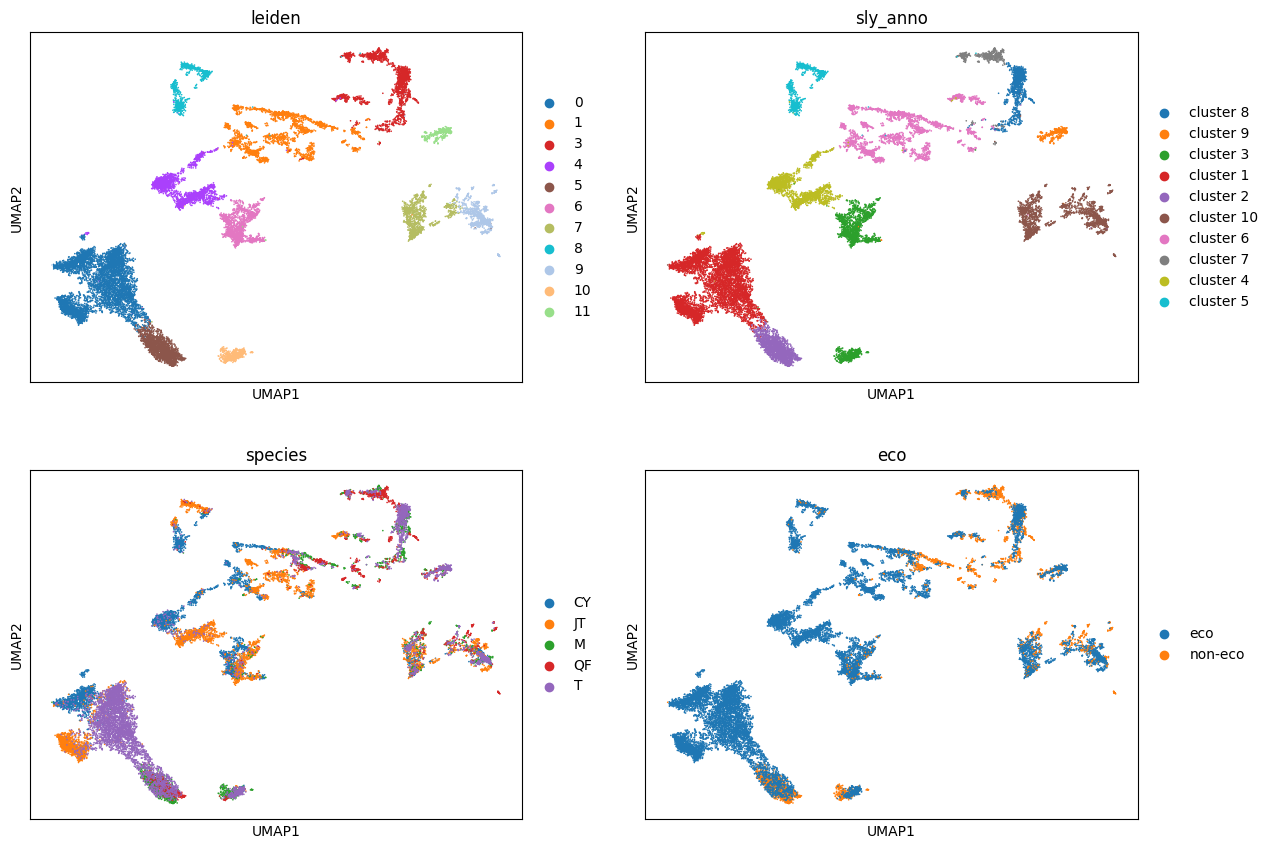

In [3]:
sc.pl.umap(scdata, color = ['leiden','sly_anno','species','eco'], ncols = 2)

## harmony 整合

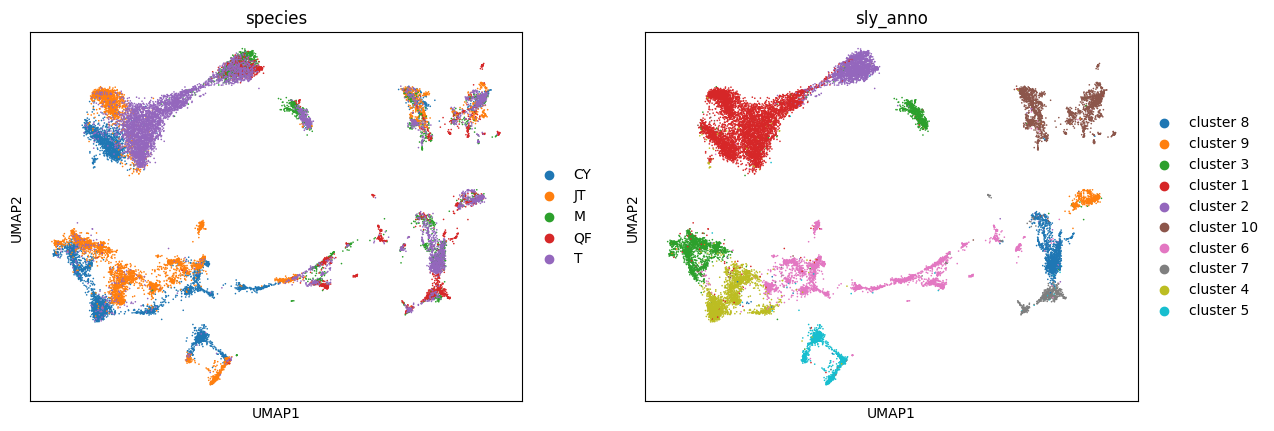

In [28]:
import scanpy.external as sce 

# sce.pp.harmony_integrate(scdata, key = 'species', theta = 2, random_state = 0, max_iter_harmony = 20, sigma = 0.1)
sc.pp.neighbors(scdata, use_rep = 'X_pca_harmony')
sc.tl.umap(scdata,min_dist = 0.1 )
sc.pl.umap(scdata, color = ['species', 'sly_anno'])

## scanorama 整合

Processing datasets M <=> QF
Processing datasets QF <=> T
Processing datasets CY <=> JT
Processing datasets JT <=> M
Processing datasets JT <=> T
Processing datasets CY <=> T


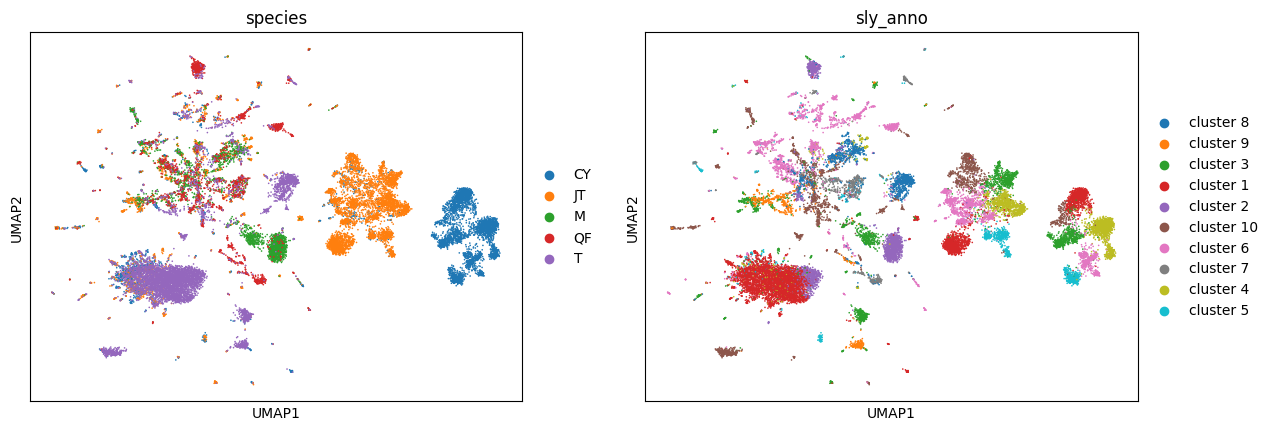

In [ ]:
# sce.pp.scanorama_integrate(scdata, key = 'species', verbose=1, alpha = 0.05)
# sc.pp.neighbors(scdata, use_rep = 'X_scanorama')
# sc.tl.umap(scdata, )
# sc.pl.umap(scdata, color = ['species', 'sly_anno'])

## 尝试使用先验引导的的批次矫正

C:\Users\sunrui\AppData\Local\Temp\ipykernel_48060\2302222457.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_map[adata.obs.index[i]] = f'{key}-{adata.obs.leiden[i]}'
C:\Users\sunrui\AppData\Local\Temp\ipykernel_48060\2302222457.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_map[adata.obs.index[i]] = f'{key}-{adata.obs.leiden[i]}'
C:\Users\sunrui\AppData\Local\Temp\ipykernel_48060\2302222457.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

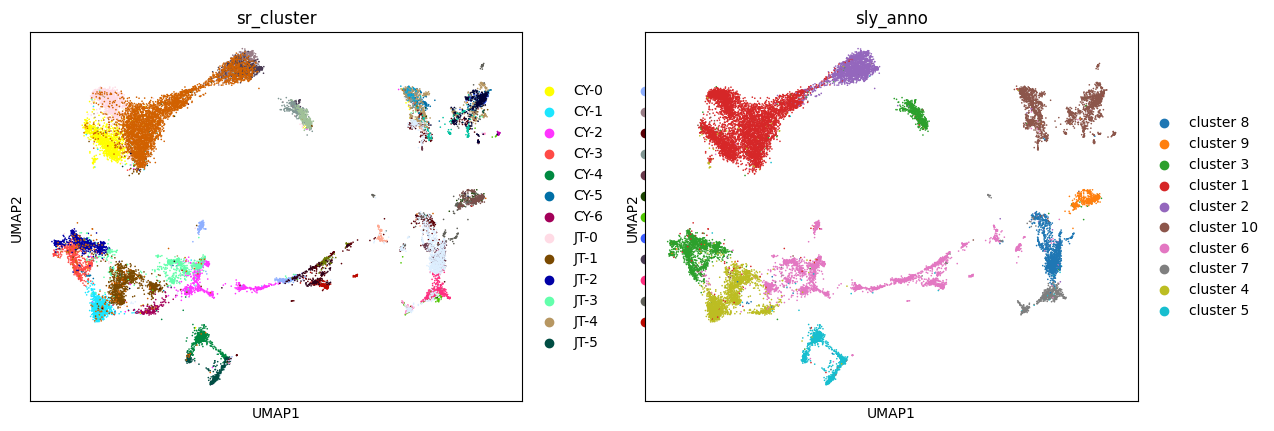

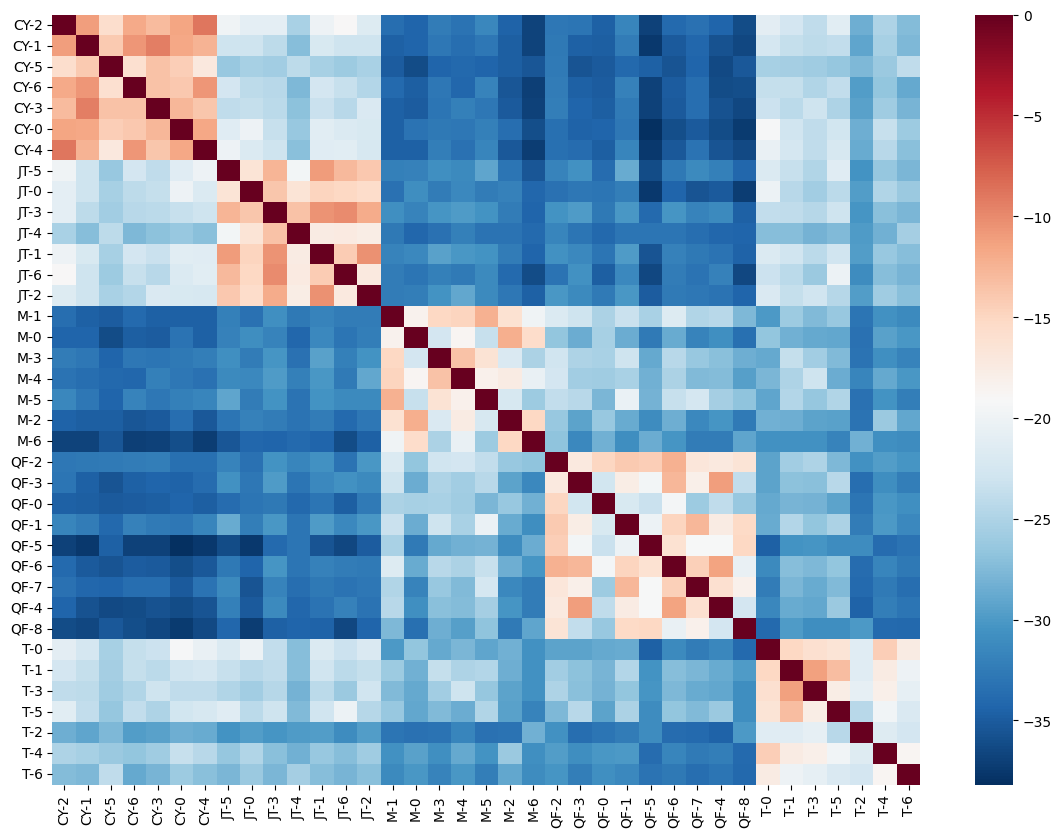

In [57]:
from scipy.spatial.distance import pdist, squareform
cluster_map = {}

for key in scdata.obs.species.unique():

    adata = scdata[scdata.obs.species == key,:]
    # sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, resolution = 0.2)

    for i in range(adata.obs.shape[0]):
        cluster_map[adata.obs.index[i]] = f'{key}-{adata.obs.leiden[i]}'
    # sc.pl.umap(adata, color = ['leiden', 'sly_anno'])
    # print('====================================================')
scdata.obs.loc[:,'sr_cluster'] = scdata.obs.index.map(cluster_map)
sc.pl.umap(scdata , color = ['sr_cluster', 'sly_anno'])

mu_list = []
for ele in scdata.obs.sr_cluster.unique():
    tmp = scdata[scdata.obs.sr_cluster == ele]
    tmp = tmp.obsm['X_pca'][:,:].mean(axis = 0)
    mu_list.append(tmp)

df = pd.DataFrame(mu_list, index = scdata.obs.sr_cluster.unique().astype(object))

distances_pdist = pdist(df.values, metric='euclidean')
corr_df = -squareform(distances_pdist)
# corr_df = np.corrcoef(df)
import matplotlib.pyplot as plt 
import seaborn as sns


plt.figure(figsize=(14,10))
sns.heatmap(corr_df, cmap = 'RdBu_r', xticklabels=df.index, yticklabels=df.index)
plt.show()
    

## cluster 相似性标准化 

同批次内部的相似性softmax 

不同批次内部softmax

之后设置阈值来确定要拉近的cluster

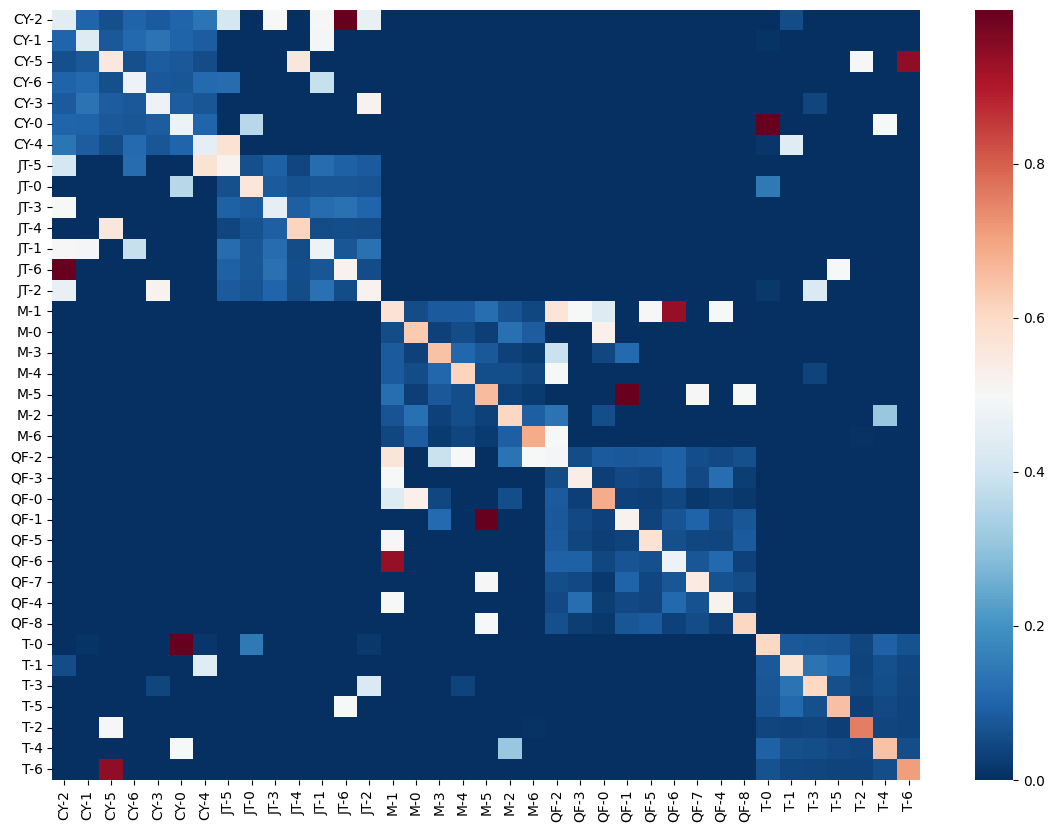

In [77]:
corr_df = pd.DataFrame(corr_df, index = df.index, columns = df.index)

def softmax(x, tau = 1):
    x = x / tau
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    softmax_x = exp_x / sum_exp_x
    return softmax_x 

batch_info  = []
for ele in corr_df.columns:
    batch_info.append(ele.split('-')[0]) 
N = len(batch_info)


new_df_list = []
for i,ele in enumerate(corr_df.columns):
    batch = ele.split('-')[0]
    batch_mask = []
    for _ in batch_info:
        if batch == _:
            batch_mask.append(True)
        else:
            batch_mask.append(False)
    batch_mask = np.array(batch_mask)

    new_corr = np.zeros(N)
    raw_corr = corr_df.iloc[i,:].values 
    new_corr[batch_mask] = softmax(raw_corr[batch_mask], tau = 7.5)
    new_corr[~batch_mask] = softmax(raw_corr[~batch_mask], tau = 0.1)
    new_df_list.append(new_corr)

new_df_list = np.array(new_df_list)
new_df_list = 0.5*(new_df_list + new_df_list.T)
new_corr_df = pd.DataFrame(new_df_list, index = corr_df.index, columns = corr_df.columns)


plt.figure(figsize=(14,10))
sns.heatmap(new_corr_df, cmap = 'RdBu_r', xticklabels=df.index, yticklabels=df.index)
plt.show()

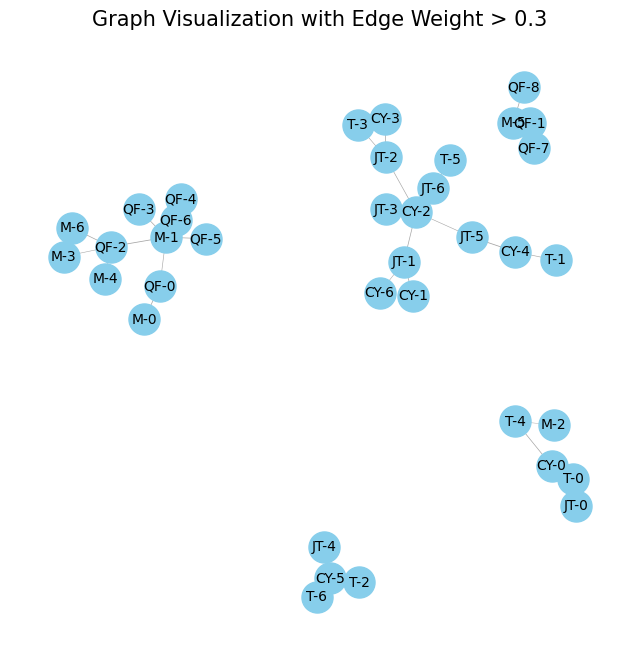

In [79]:
import networkx as nx 



def visualize_graph_from_adj_matrix(df: pd.DataFrame, threshold: float = 0.4):
    """
    根据邻接矩阵 DataFrame 可视化无向图，并设置连边强度阈值。

    参数:
    df (pd.DataFrame): 邻接矩阵，行列都是节点名称，元素是连边强度。
    threshold (float): 仅保留强度超过此阈值的连边。
    """
    
    # 1. 创建一个空的无向图
    G = nx.Graph()

    # 2. 从 DataFrame 添加节点和带有权重的边
    # 将 DataFrame 转换为长格式，方便遍历
    adj_matrix_long = df.stack().reset_index()
    adj_matrix_long.columns = ['source', 'target', 'weight']
    
    # 遍历每一行，添加满足阈值条件的边
    for _, row in adj_matrix_long.iterrows():
        source = row['source']
        target = row['target']
        weight = row['weight']
        
        # 仅保留强度大于阈值的边
        if weight > threshold:
            G.add_edge(source, target, weight=weight)
            
    # 3. 检查图是否为空，以避免错误
    if not G.edges():
        print(f"没有找到强度超过 {threshold} 的连边，请尝试降低阈值。")
        return

    # 4. 可视化图
    plt.figure(figsize=(8, 8))
    
    pos = nx.spring_layout(G, seed=42)  
    
    # 绘制节点
    # node_size 可以根据需要调整
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
    
    # 绘制边
    edges = G.edges(data=True)
    weights = [d['weight'] for u, v, d in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, edge_color='gray', alpha=0.7)

    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    # 绘制边的权重作为标签，让图更有信息
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)


    plt.title(f'Graph Visualization with Edge Weight > {threshold}', size=15)
    plt.axis('off')
    plt.show()


visualize_graph_from_adj_matrix(new_corr_df, threshold=0.3)

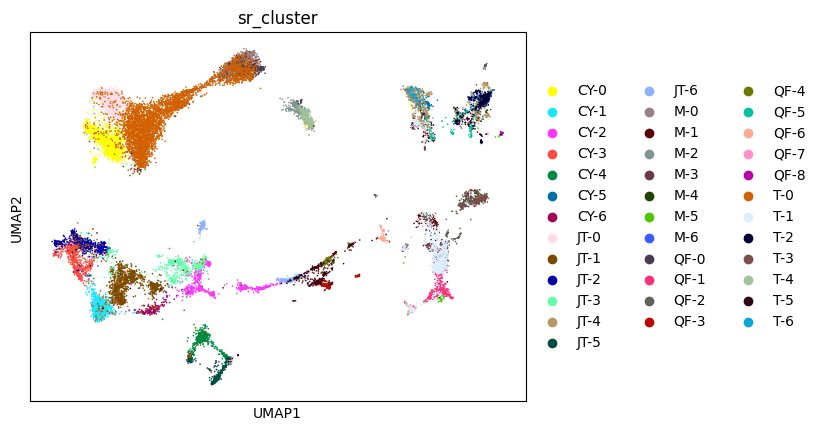

In [44]:
sc.pl.umap(scdata, color = 'sr_cluster')

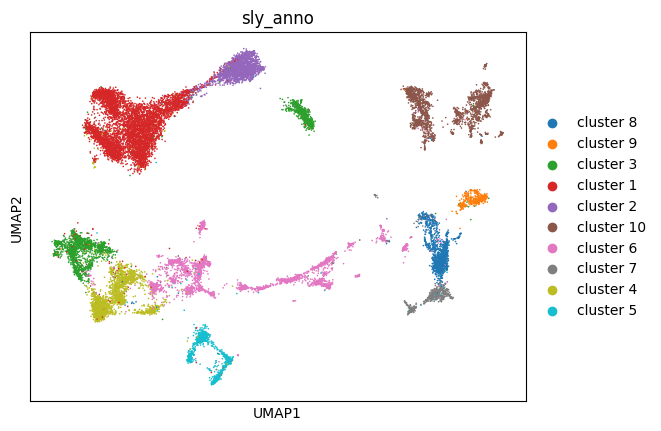

In [75]:
sc.pl.umap(scdata, color = 'sly_anno')

In [74]:
scdata

AnnData object with n_obs × n_vars = 21861 × 9911
    obs: 'species', 'tissues', 'samples', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster', 'celltype', 'coarse_celltype', 'eco', 'leiden_R', 'new_leiden', 'new_anno', 'split_label', 'sly_anno', 'sr_cluster'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltype_colors', 'dendrogram_new_anno', 'eco_colors', 'hvg', 'leiden', 'leiden_R', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'new_anno_colors', 'new_leiden_colors', 'pca', 'rank_genes_groups', 'species_colors', 'umap', 'sly_anno_colors', 'sr_cluster_colors', 'cluster_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_scanorama'
    obsp: 'connectivities', 'distances'